In [85]:
% matplotlib inline
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import utils
from utils import collect_episodes
from utils import estimate_performance as est_perf
from lqg1d import LQG1D
from tqdm import tqdm

# 1 On-Policy Reinforcement Learning with Parametric Policy

## 1.4 Experiments

In [122]:
class Policy(object):
    
    def __init__(self, theta, sigma, uniform=False, determinist=False, actions=None, states=None):
        self.theta = theta
        self.sigma = sigma
        self.uniform = uniform
        self.determinist = determinist
        self.actions = actions
        self.states_index_dict = states_index_dict
        self.states = states
    
    def draw_action(self, state):
        if(self.uniform):
            return np.random.choice(env.actions)
        elif self.determinist:
            state_index = np.argmin(np.abs(states - state))
            #print(self.states_index_dict)
            #print(state)
            #print(state_index)
            return self.actions[state_index]
        else:
            return self.theta * state + self.sigma * np.random.randn()
    
    def update(self, theta):
        self.theta = theta

In [3]:
class ConstantStep(object):
    
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, gt, t):
        return self.learning_rate * gt

In [4]:
class AdamStep(object):
    
    def __init__(self, beta1=0.9, beta2=0.999, alpha=0.01, epsilon=1e-8, m=0.0, v=0.0):
        self.beta1 = beta1
        self.beta2 = beta2
        self.alpha = alpha
        self.epsilon = epsilon
        self.m = m
        self.v = v
        
    def update(self, gt, t):
        t = t + 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * gt
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gt ** 2)
        m_hat = self.m / (1 - self.beta1 ** t)
        v_hat = self.v / (1 - self.beta2 ** t)
        return self.alpha / (np.sqrt(v_hat) + self.epsilon) * m_hat

In [5]:
def estimate_performance(paths, gamma=0.9):
    J = 0.
    n_episodes = len(paths)
    for p in paths:
        df = 1
        sum_r = 0.
        for r in p["rewards"]:
            sum_r += df * r
            df *= gamma
        J += sum_r
    return J / n_episodes

In [6]:
env = LQG1D('random')
env.sigma = 0.5

In [41]:
def LQG(env, policy, N=100, T=100, n_itr=100, discount=0.9, learning_rate=0.1, optimizer='Adam'):
    distances_to_optimality = []
    avg_return = []
    if optimizer == 'Adam':
        stepper = AdamStep(alpha=learning_rate)
    else:
        stepper = ConstantStep(learning_rate)
    theta_opt = -0.59
    #print('theta = {}'.format(env.theta))
    
    discounts = [discount ** k  for k in range(T)]
    #for t in tqdm(range(n_itr), desc='Iterations'):
    for t in range(n_itr):

        ## Observe trajectories and compute average return
        paths = collect_episodes(env, policy=policy, horizon=T, n_episodes=N)
        avg_return.append(estimate_performance(paths, gamma=discount))

        ## Compute gradient over trajectories 
        grad_J = 0

        for n in range(N):
            trajectory = paths[n]
            a = trajectory['actions'].reshape([T])
            s = trajectory['states'].reshape([T])
            R_trajectory = np.sum(trajectory['rewards'].reshape([T]) * discounts)
            tmp = np.dot(a - env.theta * s, s) / (env.sigma**2)
            grad_J += tmp * R_trajectory

        grad_J /= N

        ## Update current theta via gradient ascent using defined optimizer
        env.theta += stepper.update(grad_J, t)
        policy.update(env.theta) # update policy with new theta
        distances_to_optimality.append(np.abs(env.theta - theta_opt))
        
    return np.array(avg_return), np.array(distances_to_optimality)

In [20]:
def compute_truncated_random_theta():
    rand = np.random.randn()
    if rand > 1:
        return 1.
    elif rand < -1:
        return -1.
    else:
        return rand

In [91]:
env = LQG1D('random')
env.sigma = 0.5
rand_theta = compute_truncated_random_theta()

In [22]:
rand_theta

0.247501230845565

## Cross_Validating parameters : n_iter, N, learning_rate

In [92]:
env.theta = rand_theta
policy = Policy(env.theta, env.sigma)
avg_return, distances = LQG(env, policy)

In [24]:
env.theta

-0.26446002589458883

In [25]:
avg_return

array([ -1.66519161e+05,  -5.64885869e+04,  -1.28660427e+04,
        -1.46924715e+03,  -2.33329174e+02,  -1.52354104e+02,
        -1.00496318e+02,  -8.95495821e+01,  -8.08012473e+01,
        -7.55706981e+01,  -6.34592480e+01,  -5.60558532e+01,
        -5.58031619e+01,  -5.55584877e+01,  -5.28954447e+01,
        -5.15963135e+01,  -5.37532546e+01,  -4.28441743e+01,
        -3.99189231e+01,  -5.26737854e+01,  -3.73055631e+01,
        -4.34150421e+01,  -4.65491666e+01,  -4.51820549e+01,
        -4.29932356e+01,  -3.83638810e+01,  -4.30555225e+01,
        -4.36400193e+01,  -3.53765358e+01,  -3.82758121e+01,
        -4.63434231e+01,  -4.59283344e+01,  -4.15615866e+01,
        -3.96528998e+01,  -4.34887723e+01,  -4.00916485e+01,
        -3.87852299e+01,  -3.98240585e+01,  -4.71350301e+01,
        -4.07218764e+01,  -3.89849523e+01,  -3.75885615e+01,
        -3.39149370e+01,  -3.72734225e+01,  -3.50406537e+01,
        -4.09535335e+01,  -3.33037651e+01,  -3.43037941e+01,
        -3.61197690e+01,

In [26]:
distances

array([ 0.73750123,  0.68485528,  0.64147773,  0.60636996,  0.57669632,
        0.55112108,  0.52878556,  0.50909515,  0.49161486,  0.47601391,
        0.46203231,  0.44946097,  0.43812742,  0.42788832,  0.41862187,
        0.41022418,  0.40260486,  0.39568535,  0.38939651,  0.3836773 ,
        0.37847348,  0.3737367 ,  0.36942368,  0.36549573,  0.36191771,
        0.3586581 ,  0.35568811,  0.35298197,  0.35051636,  0.34827001,
        0.34622334,  0.34435884,  0.34266031,  0.34111322,  0.33970416,
        0.33842083,  0.33725224,  0.33618826,  0.33521968,  0.33433806,
        0.33353564,  0.33280548,  0.33214114,  0.33153674,  0.33098695,
        0.33048691,  0.3300322 ,  0.32961878,  0.32924296,  0.32890123,
        0.32859065,  0.32830844,  0.32805206,  0.32781899,  0.32760733,
        0.32741502,  0.32724033,  0.32708178,  0.3269377 ,  0.32680677,
        0.32668792,  0.32657999,  0.32648206,  0.32639317,  0.32631262,
        0.3262396 ,  0.32617328,  0.32611319,  0.32605869,  0.32

In [27]:
env.theta = rand_theta
policy = Policy(env.theta, env.sigma)
avg_return, distances = LQG(env, policy, n_itr=600)

Iterations: 100%|██████████| 600/600 [02:20<00:00,  4.26it/s]


In [28]:
avg_return

array([ -1.72388727e+05,  -5.20094549e+04,  -7.85268833e+03,
        -3.83387341e+02,  -1.52523620e+02,  -9.23366668e+01,
        -6.82222055e+01,  -6.97439323e+01,  -5.89111617e+01,
        -5.65547134e+01,  -4.84925962e+01,  -4.66118125e+01,
        -4.67855070e+01,  -4.47294516e+01,  -4.31344238e+01,
        -3.66993581e+01,  -3.73319952e+01,  -4.44080149e+01,
        -4.34507864e+01,  -3.83926384e+01,  -3.72113025e+01,
        -3.69457816e+01,  -3.84249942e+01,  -3.79494056e+01,
        -3.39699691e+01,  -3.81569854e+01,  -3.39774368e+01,
        -3.40197309e+01,  -3.85419884e+01,  -3.21690046e+01,
        -3.16576823e+01,  -3.35149406e+01,  -3.28449596e+01,
        -3.51358608e+01,  -3.01809366e+01,  -3.67593443e+01,
        -3.08638330e+01,  -3.09075045e+01,  -3.56529253e+01,
        -3.23252548e+01,  -3.82904908e+01,  -3.67651605e+01,
        -3.37276751e+01,  -3.42515717e+01,  -3.34408998e+01,
        -3.21338039e+01,  -3.92137270e+01,  -3.28094321e+01,
        -3.28940043e+01,

In [29]:
distances

array([ 0.73750123,  0.6715266 ,  0.62030377,  0.57832503,  0.54284336,
        0.51226266,  0.48555626,  0.46201278,  0.44111223,  0.42245884,
        0.40574196,  0.39071123,  0.377161  ,  0.36491943,  0.35384108,
        0.34380129,  0.33469222,  0.32641981,  0.31890146,  0.31206415,
        0.30584318,  0.30018063,  0.29502473,  0.29032907,  0.28605179,
        0.28215512,  0.27860491,  0.27537027,  0.27242313,  0.26973795,
        0.26729155,  0.26506279,  0.26303243,  0.26118305,  0.25949871,
        0.25796478,  0.25656805,  0.2552964 ,  0.25413879,  0.25308515,
        0.25212626,  0.25125369,  0.25045988,  0.24973779,  0.24908103,
        0.24848378,  0.24794076,  0.24744705,  0.24699838,  0.24659063,
        0.24622008,  0.2458833 ,  0.24557733,  0.24529938,  0.24504695,
        0.24481774,  0.24460961,  0.24442067,  0.2442492 ,  0.24409362,
        0.24395239,  0.24382423,  0.24370781,  0.24360213,  0.24350627,
        0.24341934,  0.24334046,  0.24326886,  0.24320385,  0.24

In [30]:
env.theta

-0.3476131965906723

In [31]:
env.theta = rand_theta
policy = Policy(env.theta, env.sigma)
avg_return, distances = LQG(env, policy, N=500)

Iterations: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


In [32]:
env.theta

-0.39845302676821404

In [33]:
avg_return

array([ -1.73356977e+05,  -3.02290589e+05,  -4.13040987e+05,
        -3.85937711e+05,  -3.47365840e+05,  -3.13964714e+05,
        -2.75393813e+05,  -2.25769732e+05,  -1.62362310e+05,
        -1.06728983e+05,  -4.78739721e+04,  -1.10946473e+04,
        -7.52882332e+02,  -1.77226374e+02,  -1.21200277e+02,
        -8.26101994e+01,  -7.12419741e+01,  -6.19842601e+01,
        -5.32085895e+01,  -5.02450437e+01,  -4.92992891e+01,
        -4.54883815e+01,  -4.06710758e+01,  -4.23032613e+01,
        -3.92290074e+01,  -3.75655297e+01,  -3.92968449e+01,
        -3.63231352e+01,  -3.52065738e+01,  -3.64386141e+01,
        -3.36782774e+01,  -3.34028398e+01,  -3.34997338e+01,
        -3.40916023e+01,  -3.24839657e+01,  -3.67227825e+01,
        -3.30967079e+01,  -3.08389821e+01,  -3.38915106e+01,
        -3.41479701e+01,  -3.30613893e+01,  -3.15822776e+01,
        -3.18258468e+01,  -3.37895479e+01,  -3.24185719e+01,
        -3.21600609e+01,  -3.34443778e+01,  -3.36712891e+01,
        -3.26989768e+01,

In [34]:
distances

array([ 0.93750123,  1.02738583,  1.00997412,  0.98083157,  0.94812237,
        0.92079971,  0.8815176 ,  0.82804611,  0.78068803,  0.72801345,
        0.678271  ,  0.63340034,  0.59297312,  0.55645021,  0.52339762,
        0.49344358,  0.46626634,  0.44158535,  0.41915416,  0.39875502,
        0.38019457,  0.36330033,  0.34791789,  0.33390861,  0.32114762,
        0.30952223,  0.29893054,  0.28928022,  0.28048753,  0.27247639,
        0.26517765,  0.25852836,  0.25247122,  0.24695401,  0.24192914,
        0.23735319,  0.23318658,  0.22939317,  0.22594002,  0.22279704,
        0.21993677,  0.21733416,  0.21496636,  0.2128125 ,  0.21085354,
        0.20907209,  0.20745235,  0.20597983,  0.20464133,  0.20342485,
        0.2023194 ,  0.20131501,  0.20040255,  0.19957372,  0.19882095,
        0.19813736,  0.19751666,  0.19695314,  0.1964416 ,  0.1959773 ,
        0.19555591,  0.19517354,  0.19482659,  0.19451181,  0.19422625,
        0.19396722,  0.1937323 ,  0.19351925,  0.19332607,  0.19

In [35]:
env.theta = rand_theta
policy = Policy(env.theta, env.sigma)
avg_return, distances = LQG(env, policy, N=500, learning_rate=0.01)

Iterations: 100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


In [36]:
env.theta

0.24817091842243655

In [37]:
avg_return

array([-174319.51703944, -186807.80061039, -196068.96253642,
       -195495.28009655, -199118.33840974, -186787.18550572,
       -187175.76799086, -192450.44528993, -196473.72600333,
       -199041.81136188, -203225.04301608, -204493.07354713,
       -206283.5009526 , -206758.61584904, -211327.41800737,
       -211413.77218196, -211565.53577561, -215073.52185692,
       -215630.22319685, -217604.08700729, -220529.697867  ,
       -219038.40766113, -218824.85831367, -217380.53218957,
       -211713.91494926, -201502.55844386, -202659.69258455,
       -205410.34186163, -202172.95420524, -204478.79383564,
       -204617.21201841, -196389.80884422, -191409.93055069,
       -186276.47782513, -184800.12273662, -180307.30111925,
       -183563.93368743, -178457.7708763 , -179128.63491878,
       -186164.23635414, -176781.65038209, -176994.01145482,
       -170291.63472365, -171960.82218161, -172749.64049286,
       -174405.44745214, -176326.76416627, -173150.53404368,
       -175157.94806081,

In [38]:
distances

array([ 0.84750123,  0.85657172,  0.85752567,  0.85370548,  0.84743358,
        0.84722185,  0.84882496,  0.85268444,  0.85631805,  0.85761982,
        0.85934828,  0.86213954,  0.8644349 ,  0.86432935,  0.86602572,
        0.86757773,  0.87102969,  0.87231066,  0.87133014,  0.8730835 ,
        0.87301937,  0.87092951,  0.86759997,  0.8651901 ,  0.86313113,
        0.86335999,  0.86366104,  0.86296064,  0.86240049,  0.86028863,
        0.85625469,  0.85255852,  0.84853629,  0.84539904,  0.84370641,
        0.84358027,  0.84333329,  0.84363352,  0.84391464,  0.84219285,
        0.83981014,  0.83786378,  0.83737556,  0.83632002,  0.83646057,
        0.83645456,  0.8375598 ,  0.83820539,  0.83833099,  0.83732158,
        0.83675389,  0.83773226,  0.8387557 ,  0.8394968 ,  0.83932738,
        0.83939224,  0.83905604,  0.83817505,  0.83640628,  0.83567266,
        0.83492676,  0.83383987,  0.83244267,  0.83144082,  0.82971708,
        0.82769838,  0.82665977,  0.82658391,  0.82804581,  0.82

## Compare results

In [93]:
def plot_average_experiment_results(n_exp=10, N=100, T=100, n_itr=100, discount=0.9, learning_rates=[0.1, 0.01]):
    
    optimizers = ['standard', 'Adam']
    
    ## Defining dictionnary to store values
    avg_returns = dict()
    avg_distances = dict()
    subplots = dict({'standard' : 220, 'Adam' : 222})
    
    all_returns = np.zeros([n_exp, n_itr])
    all_distances = np.zeros([n_exp, n_itr])
    
    x = np.arange(1, n_itr + 1)
    plt.figure(1, figsize=(20,20))
    
    assert((learning_rates != None) and (learning_rates != []))
    
    ## Trying out both optimizers : standar update and Adam
    for optimizer in optimizers:
        
        ## Trying different values of the learning rate
        for learning_rate in learning_rates:
            
            ## Running multiple experiments with different initial states
            for experiment in tqdm(range(n_exp), desc='experiments'):

                ## setting up the environment for the experiment
                env = LQG1D('random')
                env.sigma = 0.5
                env.theta = compute_truncated_random_theta()
                policy = Policy(env.theta, env.sigma)

                ## computing return and distances for this experiment for the given learning rate and optimizer
                avg_return, distances = LQG(env, policy, N, T, n_itr, discount, learning_rate, optimizer)
                all_returns[experiment,:] = avg_return
                all_distances[experiment,:] = distances

            ## Averaging results over experiments
            avg_returns[optimizer, learning_rate] = np.mean(all_returns, axis=0)
            avg_distances[optimizer, learning_rate] = np.mean(all_distances, axis=0)
            
            ## subplotting on the 1st column the Average Return over experiments
            plt.subplot(subplots[optimizer] + 1)
            plt.plot(x, avg_returns[optimizer, learning_rate], label='learning rate = {}'.format(learning_rate))
            plt.xlabel('Number of iterations')
            plt.ylabel('Return')
            plt.title('Average Return over {} experiments as a function of iterations with {} optimizer\n'.format(n_exp,
                                                                                                               optimizer))
            plt.legend()
            
            ## subplotting on the 2nd column the Average Return over experiments
            plt.subplot(subplots[optimizer] + 2)
            plt.plot(x, avg_distances[optimizer, learning_rate], label='learning rate = {}'.format(learning_rate))
            plt.xlabel('Number of iterations')
            plt.ylabel('Distance to optimality')
            plt.title('Average Distance to optimality over {} experiments as a function of iterations with {} optimizer\n'.format(n_exp,
                                                                                                                               optimizer))
            plt.legend()
        
    plt.show()

experiments: 100%|██████████| 10/10 [03:50<00:00, 23.03s/it]


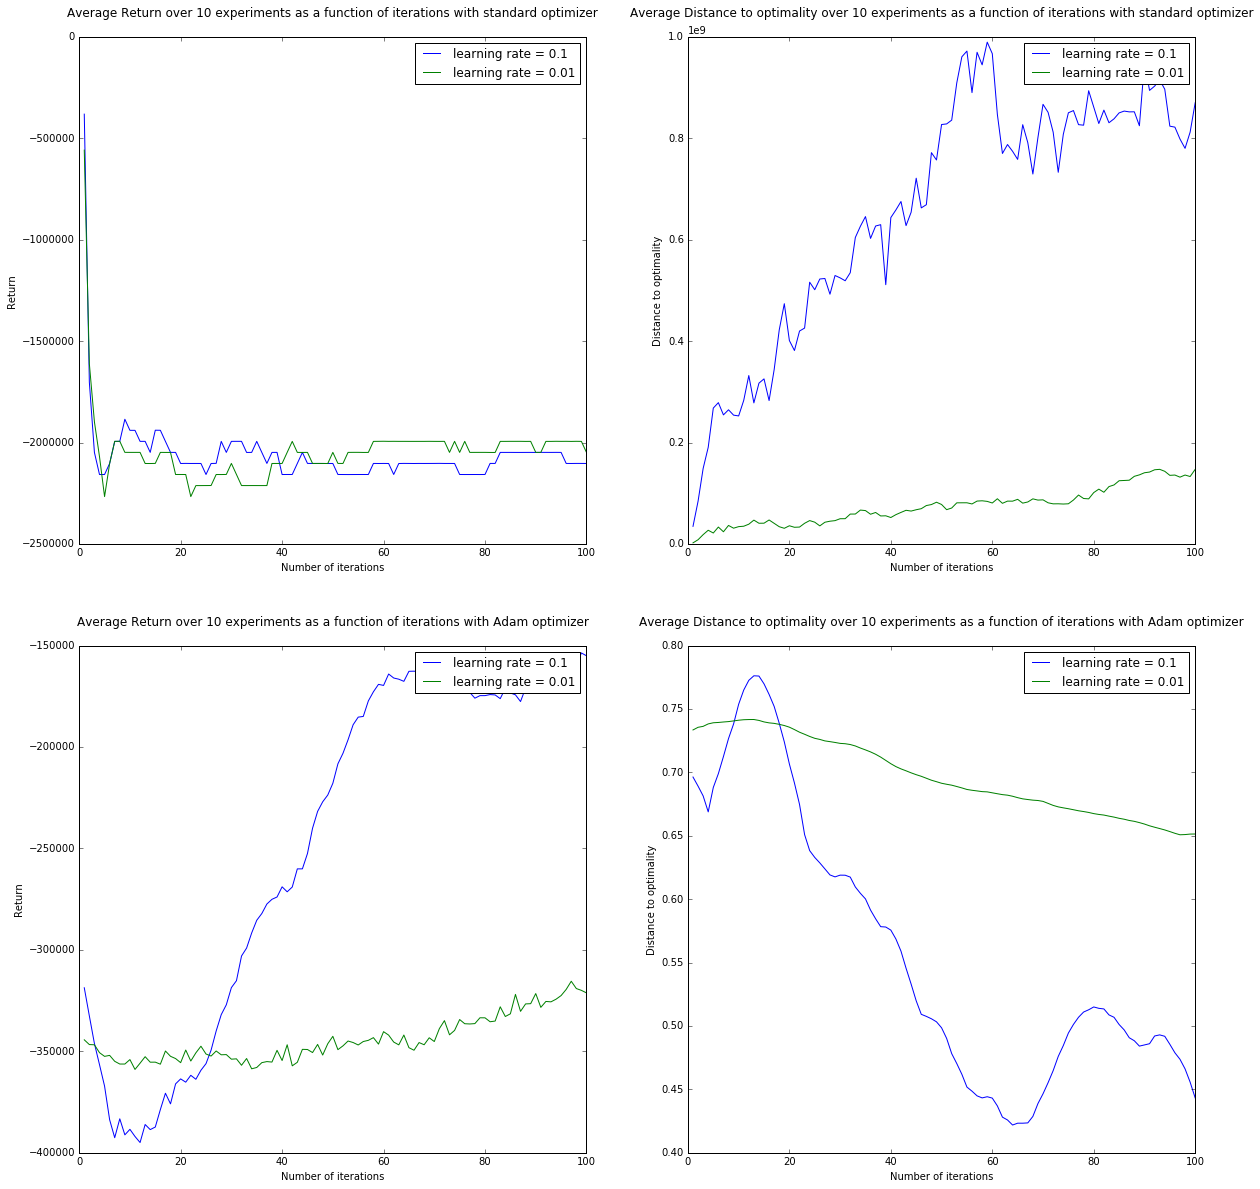

In [45]:
plot_average_experiment_results(n_exp=10, N=100, T=100, n_itr=100)

In [ ]:
plot_average_experiment_results(n_exp=50, N=100, T=100, n_itr=100)

experiments:  48%|████▊     | 24/50 [08:56<09:40, 22.33s/it]

If doing standard update rule, $\alpha_t$ is the size of the step we take in the direction of the gradient. We may overshoot it is too big when we are too close from the optimum and we may never converge if we have a too small $\alpha_t$ when being far from the optimum.
That is why we need to find the appropriate, reasonnable value for it, or use an adaptative method.

## Stochastic Gradient ascent

experiments: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


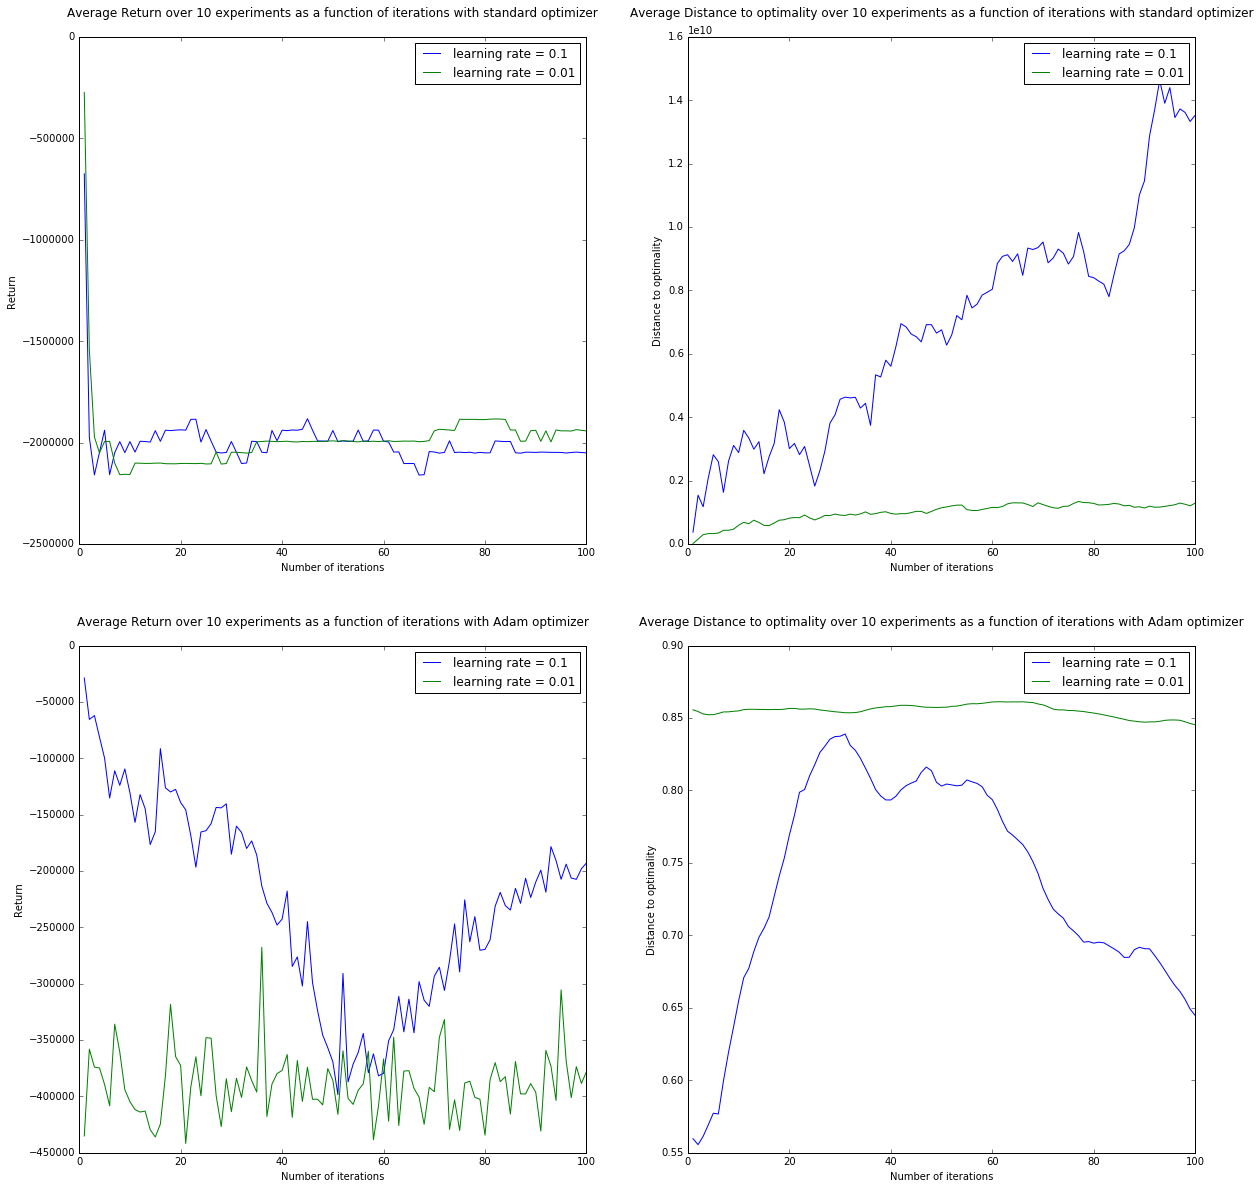

In [164]:
plot_average_experiment_results(n_exp=10, N=1, T=100, n_itr=100)

# 2 Off-Policy Reinforcement Learning with Value Function Approximation

## 2.1 Experiments

In [95]:
discount = 0.9
horizon = 50

actions = discrete_actions = np.linspace(-8, 8, 20)
states = discrete_states = np.linspace(-10, 10, 20)
env = LQG1D('random')
env.actions = actions
env.states = states

In [129]:
def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

In [131]:
from mpl_toolkits.mplot3d import Axes3D

In [159]:
def plot_optimal_Q():
    SA = make_grid(states, actions)
    S, A = SA[:, 0], SA[:, 1]

    K, cov = env.computeOptimalK(discount), 0.001
    print('Optimal K: {} Covariance S: {}'.format(K, cov))

    Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
    Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

    Q_opt = Q_fun(SA)

    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(S, A, Q_opt)
    plt.title('Optimal Q')
    plt.show()

Optimal K: [[-0.58840335]] Covariance S: 0.001


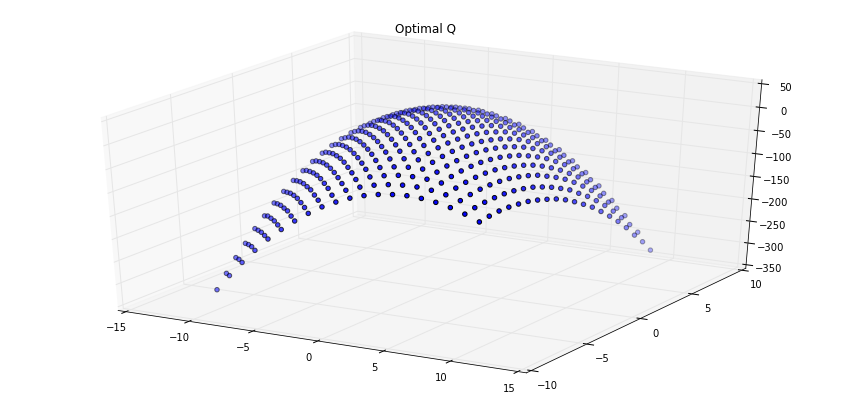

In [160]:
plot_optimal_Q()

In [65]:
def compute_y(Q, rewards, next_states_indexes, gamma=0.9):
    return np.array([ rewards[i] + gamma * np.max(Q[next_states_indexes[i],:])   for i in range(len(rewards))]).reshape([len(rewards), 1])

In [66]:
def update_Q(Q, phi, theta):
    '''
    Computes the new Q function given the new theta
    '''
    assert(phi.shape[:2] == Q.shape)
    for s in range(phi.shape[0]):
        for a in range(phi.shape[1]):
            Q[s,a] = np.dot(phi[s,a,:], theta)  

In [56]:
policy = Policy(theta=None, sigma=None, uniform=True)
paths = collect_episodes(env, policy=policy, horizon=100, n_episodes=100)

In [139]:
def FQI(env, N=100, T=100, n_itr=100, discount=0.9, learning_rate=0.1, optimizer='Adam', lamb=0.001):
    #################################################################
    # Collect the samples using the behavioural policy
    #################################################################
    # You should use discrete actions
    
    lambd = lamb
    
    n_states = len(env.states)
    n_actions = len(env.actions)
    
    #states_index_dict = dict({env.states[s] : s for s in range(n_states)})
    
    beh_policy = Policy(None, None, uniform=True)
    
    
    ## Collecting trajectories
    dataset = collect_episodes(env, n_episodes=N,
                               policy=beh_policy, horizon=T
                               )
    
    
    ## Computing phi
    phi1 = np.matlib.repmat(env.actions.reshape(1,len(env.actions)), len(env.states), 1)
    phi2 = env.actions.reshape(1,len(env.actions)) * env.states.reshape(len(env.states),1)
    phi3 = env.actions.reshape(1,len(env.actions))**2 + env.states.reshape(len(env.states),1)**2
    phi = np.stack((phi1,phi2,phi3), axis=2)

    #Stacking values over trajectories
    states = np.array([])
    actions = np.array([])
    rewards = np.array([])
    next_states = np.array([])

    for path in dataset:
        l = len(path["states"])
        states = np.concatenate((states,path["states"].reshape(l,)))
        next_states = np.concatenate((next_states,path["next_states"].reshape(l,)))
        actions = np.concatenate((actions,path["actions"]))
        rewards = np.concatenate((rewards,path["rewards"]))

    idxs = []
    for elem in next_states:
        idxs.append((np.abs(env.states-elem)).argmin())
    next_states = np.array(idxs)    
    
    states = states.reshape(1,len(states))
    actions = actions.reshape(1,len(actions))
    
    ## Compute initial parameter values to begin learning
    Z = np.concatenate((actions,states*actions,states**2+actions**2), axis=0)
    Z = Z.T
    m = np.dot(Z.T,Z) + lamb*np.eye(3)
    inverse = np.linalg.inv(m)

    big_matrix = np.dot(
                        inverse,
                        Z.T
                        )
    
    Q = np.zeros([n_states, n_actions])
    y = compute_y(Q, rewards, next_states, discount)
    theta = np.zeros(3)
    
    thetas = [theta]
    Qs = [Q]
    ys = [y]
    Js = []
    
    for k in tqdm(range(n_itr)):
        theta = np.dot(big_matrix, y)
        thetas.append(theta)
        update_Q(Q, phi, theta)
        Qs.append(Q)
        y = compute_y(Q, rewards, next_states, discount)
        ys.append(y)
        
        fqi_policy = np.argmax(Q,axis=1)
        pol = Policy(theta=None, sigma=None, determinist=True, actions=fqi_policy, states=env.states)
        
        ## evaluate policy
        Js.append(est_perf(env, pol, horizon=50, n_episodes=50))


    # to evaluate the policy you can use estimate_performance
    # plot obtained Q-function against the true one

    return Q, fqi_policy, thetas, Qs, ys, Js

In [140]:
discount = 0.9
horizon = 100

actions = discrete_actions = np.linspace(-8, 8, 20)
states = discrete_states = np.linspace(-10, 10, 20)
env = LQG1D('random')
env.actions = actions
env.states = states
env.max_action = 10.0

In [141]:
Q, fqi_policy, thetas, Qs, ys, Js = FQI(env)

100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


In [148]:
def plot_J(Js):
    plt.figure(1, figsize=(15,7))
    xs = range(len(Js))
    plt.plot(xs, Js)
    plt.xlabel('iteration k')
    plt.ylabel('$J(\pi_k)$')
    plt.title('Plotting J with learned policy through iterations')
    plt.show()

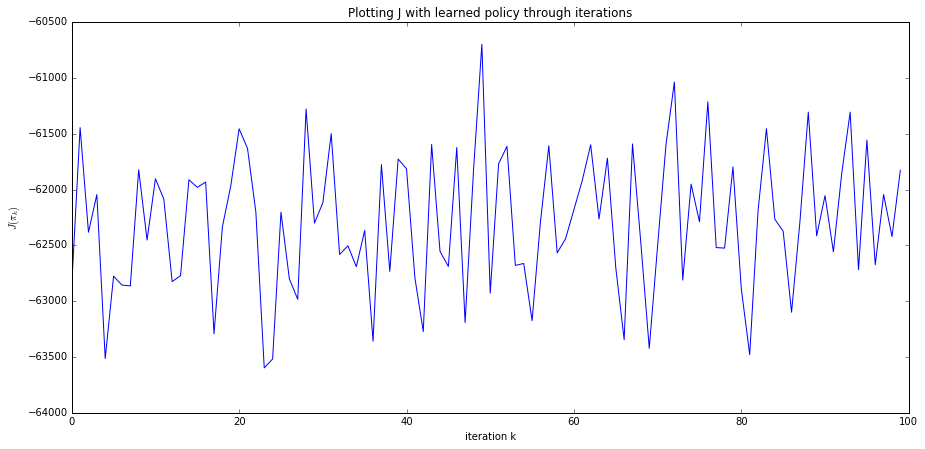

In [149]:
plot_J(Js)

In [161]:
def plot_Q(Q,env):
    xs = []
    ys = []
    zs = []
    states = env.states
    actions = env.actions
    for s in range(len(states)):
        for a in range(len(actions)):
            xs.append(states[s])
            ys.append(actions[a])
            zs.append(Q[s,a])
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, color='r')
    plt.title('Learned Q')
    plt.show()

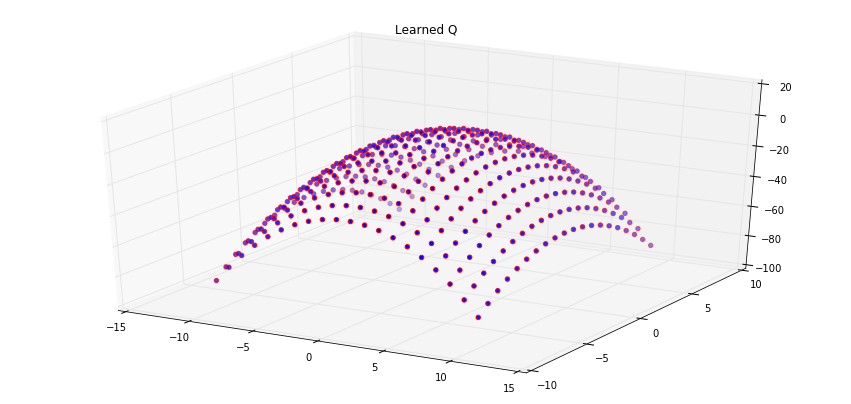

In [162]:
plot_Q(Q,env)

Optimal K: [[-0.58840335]] Covariance S: 0.001


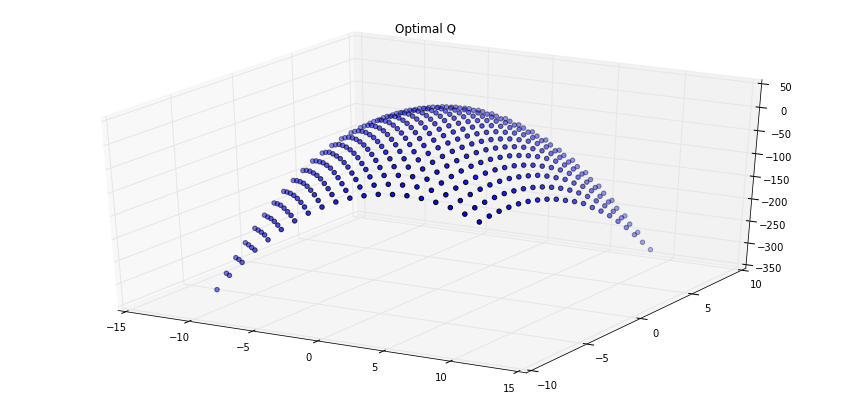

In [163]:
plot_optimal_Q()